In [1]:
__nbid__ = '0069'
__author__ = 'Ryan M. Lau <ryan.lau@noirlab.edu>, Kishalay De <kde1@mit.edu>, Alice Jacques <alice.jacques@noirlab.edu>, Astro Data Lab Team <datalab@noirlab.edu>'
__version__ = '20240927' # yyyymmdd
__datasets__ = ['pgir_dr1']
__keywords__ = ['lightcurve', 'photometry', 'time domain', 'Lomb-Scargle']

## J-band light curves from Palomar Gattini-IR DR1 catalog

*Ryan M. Lau (NSF NOIRLab), Kishalay De (MIT), Shion Murakawa (MIT), Alice Jacques (NSF NOIRLab/CSDC), & Astro Data Lab Team*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [Input search coordinates and generate light curve](#lightcurve)
* [Lomb-Scargle periodogram analysis](#lombscargle)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals & notebook summary
The goal of this notebook is to demonstrate how to generate light curves from the **Palomar Gattini-IR (PGIR) Data Release 1 (DR1)** catalog of infrared J-band light curves and also perform a basic Lomb-Scargle periodogram analysis to identify a period. 

**Description of Palomar Gattini-IR:** PGIR is a wide-field, robotic, near-infrared time domain survey covering the entire visible night sky north of declination -28.5 at a median cadence of 2 nights. The survey operates in a single filter (J-band, calibrated to the 2MASS system), with a single exposure field of view of 25 square degrees and a native pixel scale of 8.7 arcsec/pixel. Further details about the instrument and data reduction system can be found in [De et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020PASP..132b5001D/abstract). Light curves are extracted by performing Point Spread Function (PSF) photometry on the stacked images from each field visit, with the entire observing footprint divided into 1,329 fields. The first data release contains J-band light curves of approximately 286 million sources from the 2MASS catalog, with a total of approximately 50 billion photometric measurements [(Murakawa et al. 2024)](https://ui.adsabs.harvard.edu/abs/2024arXiv240601720M/abstract). 

**Science Example:** The science target in this notebook is the enigmatic NaSt1 system (also known as LS IV +005 and WR 122), which is thought to be an early-type wolf-rayet system enshrouded but a dense nebula. We will demonstrate how the PGIR light curves can be used to identify the periodic variability from this system, which was presented by [(Lau et al. 2021)](https://ui.adsabs.harvard.edu/abs/2021ApJ...922....5L/abstract).

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution

Disclaimers
-----------
Note that using the Astro Data Lab constitutes your agreement with our minimal [Disclaimers](https://datalab.noirlab.edu/disclaimers.php).

Acknowledgments
---------------
If you use **Astro Data Lab** in your published research, please include the text in your paper's Acknowledgments section:

_This research uses services or data provided by the Astro Data Lab, which is part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

If you use **SPARCL jointly with the Astro Data Lab platform** (via JupyterLab, command-line, or web interface) in your published research, please include this text below in your paper's Acknowledgments section:

_This research uses services or data provided by the SPectra Analysis and Retrievable Catalog Lab (SPARCL) and the Astro Data Lab, which are both part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

In either case **please cite the following papers**:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, https://doi.org/10.1117/12.2057445

* Astro Data Lab overview: Nikutta et al., "Data Lab - A Community Science Platform", Astronomy and Computing, 33, 2020, https://doi.org/10.1016/j.ascom.2020.100411

If you are referring to the Data Lab JupyterLab / Jupyter Notebooks, cite:

* Juneau et al., "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms", CiSE, 23, 15, 2021, https://doi.org/10.1109/MCSE.2021.3057097

If publishing in a AAS journal, also add the keyword: `\facility{Astro Data Lab}`

And if you are using SPARCL, please also add `\software{SPARCL}` and cite:

* Juneau et al., "SPARCL: SPectra Analysis and Retrievable Catalog Lab", Conference Proceedings for ADASS XXXIII, 2024
https://doi.org/10.48550/arXiv.2401.05576

The NOIRLab Library maintains [lists of proper acknowledgments](https://noirlab.edu/science/about/scientific-acknowledgments) to use when publishing papers using the Lab's facilities, data, or services.

<a class="anchor" id="import"></a>
# Imports and setup

Importing the basic python modules, the `LombScargle` function from astropy, and the `queryClient` from Astro Data Lab.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.timeseries import LombScargle

from dl import queryClient as qc

<a class="anchor" id="lightcurve"></a>
# Input search coordinates and generate light curve

### Enter RA and Dec (in degrees) of an object and cone-search radius
As an example to demonstrate the utility of PGIR DR1, we will investigate the IR variability from the heavily enshrouded massive star system NaSt1 / WR122 [(Lau et al. 2021)](https://ui.adsabs.harvard.edu/abs/2021ApJ...922....5L/abstract). We will use a 0.01 degree cone-search radius to demonstrate how searches are handled when multiple 2MASS sources are identified.


In [4]:
#Coordinates of NaSt1
ra = 283.07312
dec = 0.99564

search_rad = 0.01 # search radius in degrees

### PGIR DR1 is composed of the three following tables:

`exposures` - Metadata of each exposure included in the catalog

`photometry` - Individual photometric measurements for each source in the catalog

`sources` - Metadata and statistical moments of photometry for each 2MASS source

The columns and descriptions of each table can be found in Table 1 of [Murakawa et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024arXiv240601720M/abstract) and the [PGIR DR1 table browser](https://datalab.noirlab.edu/query.php?name=pgir_dr1.sources) at Astro Data Lab. 

We will conduct our coordinate search on the `sources` table to identify the 2MASS sources that fall within our coordinates. Using a table join on the unique 2MASS ID (`pts_key`) from the `sources` table, we can obtain the PGIR photometry of each 2MASS source from the `photometry` table. Our result table will provide the following:

`tmcra` - 2MASS right ascension of source

`tmcdec` - 2MASS declination of source

`obsjd` - Julian date of exposure start

`pts_key` - 2MASS ID number of source

`magpsf` - J-band magnitude of PGIR exposure of source

`magpsferr` - Image noise magnitude error of PGIR exposure of source

`magpsfstaterr` - Statistical magnitude error of PGIR exposure of source

`flags` - Bit-value of the flags of exposure of source

In [5]:
q = f"""SELECT S.pts_key, S.tmcra, S.tmcdec, P.obsjd, P.magpsf, P.magpsferr, P.magpsfstaterr, P.flags
FROM pgir_dr1.sources as S
JOIN pgir_dr1.photometry as P on S.pts_key = P.pts_key
WHERE q3c_radial_query(S.tmcra, S.tmcdec, {ra}, {dec}, {search_rad})
"""
re = qc.query(sql=q, fmt='pandas')

print('%i unique 2MASS sources found' % len(np.unique(re['pts_key'])))

17 unique 2MASS sources found


The search has identified 17 unique 2MASS sources from the search:

In [6]:
np.unique(re['pts_key'])

array([673172927, 673172931, 673172956, 673172967, 673173015, 673173034,
       673173036, 673173040, 673173065, 673173067, 673173083, 673173090,
       673173119, 673173147, 673173151, 673173181, 673173185])

The following cell identifies the closest source based on its proximity to the search coordinates and defines a new light curve table of that closest source.

In [7]:
re['dist'] = np.sqrt((ra-re['tmcra'])**2+(dec-re['tmcdec'])**2)
re = re.sort_values('dist')
re = re.reset_index(drop=True)

re_best = re[re['pts_key']==re['pts_key'][0]]
re_best

,pts_key,tmcra,tmcdec,obsjd,magpsf,magpsferr,magpsfstaterr,flags,dist
0,673173034,283.07312,0.995639,2459867.8,9.885060,5.506587e-02,0.003874,32,1.000000e-06
1,673173034,283.07312,0.995639,2459722.8,9.639231,5.945242e-02,0.003415,33,1.000000e-06
2,673173034,283.07312,0.995639,2459721.8,9.656757,6.217199e-02,0.003503,33,1.000000e-06
3,673173034,283.07312,0.995639,2459719.8,9.629660,4.645084e-02,0.003359,33,1.000000e-06
4,673173034,283.07312,0.995639,2459717.8,9.679220,5.606063e-02,0.003443,33,1.000000e-06
...,...,...,...,...,...,...,...,...,...
1605,673173034,283.07312,0.995639,2459375.8,9.688159,6.854054e-02,0.003479,33,1.000000e-06
1606,673173034,283.07312,0.995639,2459374.8,9.918835,7.887600e-02,0.004528,33,1.000000e-06
1607,673173034,283.07312,0.995639,2459386.8,10.392316,1.221390e-01,0.004804,33,1.000000e-06
1608,673173034,283.07312,0.995639,2458425.5,29.796688,9.745351e+06,NaN,36,1.000000e-06


In order to filter out spurious detections, we apply a signal-to-noise ratio (SNR) threshold using both the statistical magnitude error (`magpsfstaterr`) and the sampled magnitude error (`magpsferr`). Negative errors are also filtered out.

In [8]:
snr_thresh = 10

positive_err = ((re_best['magpsferr'] > 0) &
                (re_best['magpsfstaterr'] > 0) & 
                (1 / re_best['magpsfstaterr'] > snr_thresh) &
                (1 / re_best['magpsferr'] > snr_thresh))

re_best = re_best[positive_err]

The following cell reads the quality flags for each epoch. Uncomment flags you wish to apply to your data. In this notebook, we will not utilize the flags.

Note that NaSt1 has nearby sources that lead to aperture contamination, which will lead to many of the epochs having the aperture contamination (F6) flag. However, since we are only interested in the variability, the contamination is not a major issue.

In [9]:
flags = re_best['flags']
procflags = []
for flagval in flags:
    totflag = True
    if flagval - 32 >= 0:
        #totflag = False # remove measurements with aperture contamination (F6).
        flagval -= 32
    if flagval - 16 >= 0:
        #totflag = False # remove measurements with zero point deviation (F5).
        flagval -= 16
    if flagval - 8 >= 0:
        #totflag = False # remove measurements with bad airmass (F4).
        flagval -= 8
    if flagval - 4 >= 0:
        #totflag = False # remove measurements with magnitudes outside of that is recommended (F3).
        flagval -= 4
    if flagval - 2 >= 0:
        #totflag = False # remove measurements with pixel saturation (F2).
        flagval -= 2
    if flagval - 1 >= 0:
        #totflag = False # remove measurements on the west meridian side (F1).
        flagval -= 1
    procflags.append(totflag)

### Plotting PGIR J-band Light Curve

We can now plot the PGIR J-band light curve of our target (NaSt1; `pts_key = 673173034`) with photometry that has passed our SNR threshold cut and the flags that we set in the previous cell. 

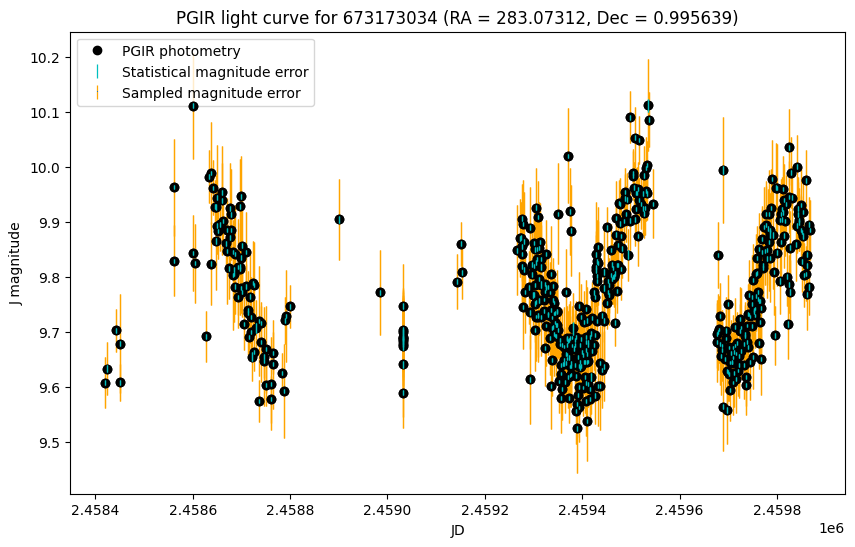

In [10]:
plt.figure(figsize=(10,6))

plt.errorbar(re_best[procflags]['obsjd'], re_best[procflags]['magpsf'],
             fmt='o', color='k', ms=6, ls='', zorder=10, label='PGIR photometry')

plt.errorbar(re_best[procflags]['obsjd'], re_best[procflags]['magpsf'],
             yerr = re_best[procflags]['magpsfstaterr'],
             fmt=',', color='none', ms=6, zorder=20, elinewidth=0.9, ecolor='c',
             label='Statistical magnitude error')

plt.errorbar(re_best[procflags]['obsjd'], re_best[procflags]['magpsf'],
             yerr = re_best[procflags]['magpsferr'],
             fmt=',', ms=6, zorder=0, elinewidth=0.9, ecolor='orange',
             label='Sampled magnitude error')

plt.xlabel('JD')
plt.ylabel('J magnitude')
plt.title(f"PGIR light curve for {re_best['pts_key'][0]} (RA = {re_best['tmcra'][0]}, Dec = {re_best['tmcdec'][0]})") 
plt.legend()
plt.show()

<a class="anchor" id="lombscargle"></a>
# Lomb-Scargle periodogram analysis

The light curve of NaSt1 appears to exhibit periodic variability. Here, we conduct a Lomb-Scargle periodogram analysis to verify the period and compare to the results from [(Lau et al. 2021)](https://ui.adsabs.harvard.edu/abs/2021ApJ...922....5L/abstract). 

For the periodogram analysis, we run the `LombScargle` function to search for periods between 3 - 500 days from the PGIR J-band light curve of NaSt1.

In [11]:
min_period = 3.0 * u.day
max_period = 500 * u.day

min_freq_search = 1.0 / max_period
max_freq_search = 1.0 / min_period

frequency, power = LombScargle(np.array(re_best[procflags]['obsjd']) * u.day,
                               re_best[procflags]['magpsf']).autopower(minimum_frequency=min_freq_search,
                                                                       maximum_frequency=max_freq_search)

freq_peak = frequency[np.argmax(power)].value

print('The period corresponding to the peak frequency is %.1f d' % (1 / freq_peak))

The period corresponding to the peak frequency is 308.3 d


Below, we plot the Lomb-Scargle periodograms as a function of frequency and period.

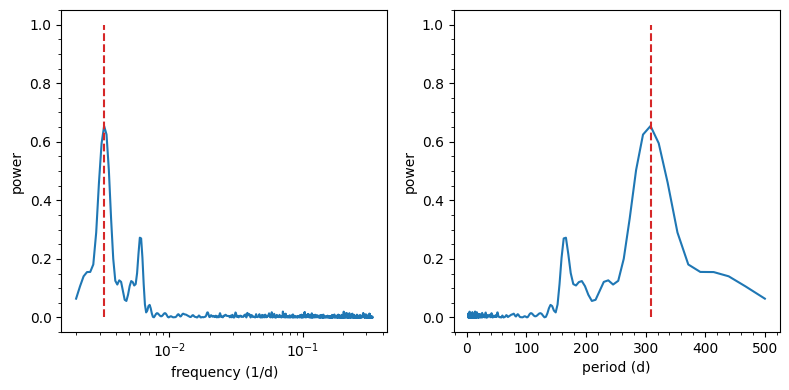

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

plt.sca(ax[0])
plt.plot(frequency, power)
plt.vlines(freq_peak, 0, 1, linestyle='--', color='tab:red')
plt.minorticks_on()
plt.xlabel('frequency (1/d)')
plt.xscale('log')
plt.ylabel('power')

plt.sca(ax[1])
plt.plot(1 / frequency, power)
plt.vlines(1 / freq_peak, 0, 1, linestyle='--', color='tab:red')
plt.minorticks_on()
plt.xlabel('period (d)')
plt.ylabel('power')

plt.tight_layout()
plt.show()

The strongest peak in the periodogram indeed corresponds to a period of 308 days, which is consistent with the variability period derived for NaSt1 by [(Lau et al. 2021)](https://ui.adsabs.harvard.edu/abs/2021ApJ...922....5L/abstract).

<a class="anchor" id="resources"></a>
# Resources and references

De et al. (2020): *Palomar Gattini-IR: Survey Overview, Data Processing System, On-sky Performance and First Results*. Publications of the Astronomical Society of the Pacific, 132, 025001: https://ui.adsabs.harvard.edu/abs/2020PASP..132b5001D/abstract

Lau et al. (2021): *Discovery of a 310 Day Period from the Enshrouded Massive System NaSt1 (WR 122)*. The Astrophysical Journal, 922, 5: https://ui.adsabs.harvard.edu/abs/2021ApJ...922....5L/abstract

Murakawa et al. (2024): *The first Palomar Gattini-IR catalog of J-band light curves: construction and public data release*.  
arXiv:2406.01720: https://ui.adsabs.harvard.edu/abs/2024arXiv240601720M/abstract